In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


trainX.shape, trainY.shape:  (10000, 3072) (10000, 10)
testX.shape, testY.shape:  (2000, 3072) (2000, 10)

 Number of feature maps: 10,10
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch  0 --- Test Accuracy:  0.099
Epoch  10 --- Test Accuracy:  0.101
Epoch  20 --- Test Accuracy:  0.143
Epoch  30 --- Test Accuracy:  0.231
Epoch  40 --- Test Accuracy:  0.262
Epoch  50 --- Test Accuracy:  0.279
Epoch  60 --- Test Accuracy:  0.296
Epoch  70 --- Test Accuracy:  0.312
Epoch  80 --- Test Accuracy:  0.3115
Epoch  90 --- Test Accuracy:  0.3175

 Number of feature maps: 10,20
Epoch  0 --- Test Accuracy:  0.0995
Epoch  10 --- Test Accuracy:  0.172
Epoch  20 --- Test Accuracy:  0.2285
Epoch  30 --- Test Accuracy:  0.2575
Epoch  40 --- Test Accuracy:  0.2835
Epoch  50 --- Test Accuracy:  0.288
Epoch  60 --- Test Accuracy:  0.304
Epoch  70 --- Test Accuracy:  0.3185
Epoch  80 --- Test Accuracy:  0.3315
Epoch  90 --- Test Accura

FileNotFoundError: ignored

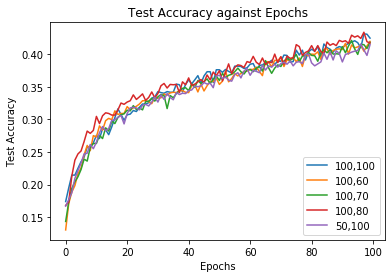

In [0]:
import math
import tensorflow as tf
import numpy as np
import random
import pylab as plt
import pickle
import os

if not os.path.isdir('figures'):
    print('creating the figures folder')
    os.makedirs('figures')

NUM_CLASSES = 10
IMG_SIZE = 32
NUM_CHANNELS = 3
learning_rate = 0.001
epochs = 100
batch_size = 128

seed = 10
random.seed(seed)
np.random.seed(seed)
tf.set_random_seed(seed)


def load_data(file):
    with open(file, 'rb') as fo:
        try:
            samples = pickle.load(fo)
        except UnicodeDecodeError:  # python 3.x
            fo.seek(0)
            samples = pickle.load(fo, encoding='latin1')

    data, labels = samples['data'], samples['labels']

    data = np.array(data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)

    labels_ = np.zeros([labels.shape[0], NUM_CLASSES])
    labels_[np.arange(labels.shape[0]), labels - 1] = 1

    data = (data - np.min(data, axis=0)) / (np.max(data, axis=0)) #normalization
    return data, labels_


def cnn(images, num_features1, num_features2):
    images = tf.reshape(images, [-1, IMG_SIZE, IMG_SIZE, NUM_CHANNELS])

    keep_prob = tf.placeholder(tf.float32)

    # C1: 1st convolutional layer
    W_conv1 = weight_variable_conv(9, 9, NUM_CHANNELS, num_features1)
    b_conv1 = bias_variable([num_features1])
    u_conv1 = tf.nn.conv2d(images, W_conv1, strides=[1, 1, 1, 1], padding='VALID') + b_conv1
    h_conv1 = tf.nn.relu(u_conv1)

    # S1: 1st Pooling layer
    h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    h_pool1 = tf.nn.dropout(h_pool1, keep_prob)

    # C2: 2nd convolutional layer
    W_conv2 = weight_variable_conv(5, 5, num_features1, num_features2)
    b_conv2 = bias_variable([num_features2])
    u_conv2 = tf.nn.conv2d(h_pool1, W_conv2, strides=[1, 1, 1, 1], padding='VALID') + b_conv2
    h_conv2 = tf.nn.relu(u_conv2)

    # S2: 2nd Pooling layer
    h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    h_pool2 = tf.nn.dropout(h_pool2, keep_prob)

    # F3: fully connected layer of size 300
    dim = h_pool2.get_shape()[1].value * h_pool2.get_shape()[2].value * h_pool2.get_shape()[3].value

    W_fc1 = weight_variable([dim, 300])
    b_fc1 = bias_variable([300])
    h_pool2_flat = tf.reshape(h_pool2, [-1, dim])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)


    # F4: Softmax layer of size 10
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    W_fc2 = tf.Variable(tf.truncated_normal([300, NUM_CLASSES], stddev=1.0 / np.sqrt(dim)), name='weights_3')
    b_fc2 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_3')

    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

    return h_conv1, h_pool1, h_conv2, h_pool2, y_conv, keep_prob


def weight_variable_conv(width, height, input_m, output_m):
    initial = tf.truncated_normal([width, height, input_m, output_m], stddev=1.0 / np.sqrt(input_m * width * height))
    return tf.Variable(initial)

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.zeros(shape)
    return tf.Variable(initial)


def train_tf_model(trainX, trainY, testX, testY, NUM_CLASSES, NUM_CHANNELS, IMG_SIZE, learning_rate, epochs, batch_size, num_features1, num_features2, all_test_acc, last_test_acc):
  # Create the model
  x = tf.placeholder(tf.float32, [None, IMG_SIZE * IMG_SIZE * NUM_CHANNELS])
  y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

  label = str(num_features1) + ',' + str(num_features2)
  print('\n',"Number of feature maps: "+ label)

  h_conv1, h_pool1, h_conv2, h_pool2, logits , keep_prob = cnn(x, num_features1, num_features2)

  cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
  loss = tf.reduce_mean(cross_entropy)

  train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  correct_prediction = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1)), tf.float32)
  accuracy = tf.reduce_mean(correct_prediction)

  N = len(trainX)
  idx = np.arange(N)
  with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())

      test_acc = []
      for e in range(epochs):
          np.random.shuffle(idx)
          trainX, trainY = trainX[idx], trainY[idx]

          for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
              _ = sess.run([train_step], {x: trainX[start:end], y_: trainY[start:end], keep_prob: 1.0})

          accuracy_ = sess.run([accuracy], {x: testX, y_: testY, keep_prob: 1.0})
          test_acc.append(accuracy_[0])

          if e % 10 == 0:
            print('Epoch ', e, '--- Test Accuracy: ', test_acc[e])

      all_test_acc[label] = test_acc 
      last_test_acc[label] = test_acc[-1]

  return [all_test_acc, last_test_acc]


def main():
    trainX, trainY = load_data('drive/My Drive/CZ4042 Neural Network project/project 2/Part A/data_batch_1')
    print('trainX.shape, trainY.shape: ', trainX.shape, trainY.shape)   

    testX, testY = load_data('drive/My Drive/CZ4042 Neural Network project/project 2/Part A/test_batch_trim')
    print('testX.shape, testY.shape: ', testX.shape, testY.shape)  

    trainX = (trainX - np.min(trainX, axis = 0))/np.max(trainX, axis = 0)
    testX = (testX - np.min(testX, axis = 0))/np.max(testX, axis = 0)

    #using dictionaries to track num_features with its respective test accuracies as key-value pairs
    all_test_acc = {}
    last_test_acc = {}
    for num_features1 in range(10, 101, 10):
      for num_features2 in range(10, 101, 10):
        all_test_acc, last_test_acc = train_tf_model(trainX, trainY, testX, testY, NUM_CLASSES, NUM_CHANNELS, IMG_SIZE, learning_rate, epochs, batch_size, num_features1, num_features2, all_test_acc, last_test_acc)

    sorted_last_test_acc = {}
    for key in sorted(last_test_acc, key=last_test_acc.get, reverse=True)[:5]: 
        sorted_last_test_acc.update({key: last_test_acc[key]}) #append

    print(sorted_last_test_acc) 

    #Test Accuracies Top 5
    plt.figure(1)
    for key_label in sorted_last_test_acc:
        plt.plot(range(epochs), all_test_acc.get(key_label), label=key_label)
    plt.title('Test Accuracy against Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Test Accuracy')
    plt.legend(loc='best')
    plt.savefig('./figures/A2-test-accuracy.png')
    plt.show()


    # #Test Accuracies LAST 10 epochs
    # plt.figure(2)
    # for key_label in sorted_last_test_acc:
    #     plt.plot(range(epochs), all_test_acc.get(key_label)[-10:], label=key_label)
    # plt.title('Test Accuracy against Epochs (Last 10 Epochs)')
    # plt.xlabel('Epochs')
    # plt.ylabel('Test Accuracy')
    # plt.legend(loc='best')
    # plt.savefig('./figures/Q2_FeatureMaps_vs_Epochs_last10.png')
    # plt.show()



if __name__ == '__main__':
    main()